# Training and Basic Evaluation for a 2D Binary Classifier

If using MedMNIST for the first time, you will need to install medmnist.

In [1]:
#!pip install medmnist

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras import layers, optimizers, losses, metrics

import tensorflow as tf

import medmnist
from medmnist import INFO

import sys
sys.path.insert(0,"../")

import dataset_without_pytorch

from functions import split_data, get_label_counts, build_basic_model, argmax_array, generate_training_mixup_images
from plotting_functions import plot_history

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


We set some of our parameters here. The data flag is 'pneumoniamnist' - a binary pneumonia dataset. 

In [3]:
data_flag = 'pneumoniamnist'

download = True

image_size = 128

info = INFO[data_flag]

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [4]:
# load the data
train_dataset = DataClass(split='train', download=download, size = image_size)
test_dataset = DataClass(split='test', download=download, size = image_size)
val_dataset = DataClass(split='val', download=download, size = image_size)

Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\pneumoniamnist_128.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\pneumoniamnist_128.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\pneumoniamnist_128.npz


In [6]:
print(train_dataset)

Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: C:\Users\Will Poulett\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0


Here we split our data into train, validation, and 2 testing datasets. One is for MUBA, one is for further evaluation. 

In [5]:
RANDOM_SEED = 1

X_train, y_train, X_val, y_val, X_test_A, y_test_A, X_test_B, y_test_B = split_data(
  train_dataset, test_dataset, val_dataset, RANDOM_SEED = RANDOM_SEED, one_hot_encoded = True, num_classes=2, image_size = 128)

In [6]:
get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names = ["Normal","Pneumonia"])


Train
{(0, 1): 3494, (1, 0): 1214}  ['Normal', 'Pneumonia']

Val
{(0, 1): 389, (1, 0): 135}  ['Normal', 'Pneumonia']

Test A
{(0, 1): 117, (1, 0): 70}  ['Normal', 'Pneumonia']

Test B
{(0, 1): 273, (1, 0): 164}  ['Normal', 'Pneumonia']


In [7]:
X_train_oversample = []
y_train_oversample = []

for X, y in zip(X_train,y_train):
    if y[0] == 1: # Normal is undersampled
        for i in range(3):
            X_train_oversample.append(X)
            y_train_oversample.append(y)
    else:
        X_train_oversample.append(X)
        y_train_oversample.append(y)

X_train_oversample = np.array(X_train_oversample).reshape(-1, image_size, image_size, 1)
y_train_oversample = np.array(y_train_oversample)

In [14]:
X_train_oversample = np.repeat(X_train_oversample, 3, -1)
X_val = np.repeat(X_val, 3, -1)
X_test_A = np.repeat(X_test_A, 3, -1)
X_test_B = np.repeat(X_test_B, 3, -1)

In [15]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 25,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train_oversample)

## EfficientNet

This first model we call 'basic' as we are not augmenting the data in any way during training. 

In [12]:
# The code is creating a ResNet152V2 model with pre-trained weights from the ImageNet dataset. 
# The base model is frozen, meaning its weights will not be updated during training. 
# The code then appends additional layers on top of the base model for transfer learning.

from tensorflow.keras.applications import EfficientNetV2S
base_model = EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=((image_size, image_size, 3)),
    classes=2,)

# Freeze the base_model
base_model.trainable = False

# append my own layers on the top of the model for Transfer Learning
x = base_model.output

# 1st conv block
x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 2nd conv block
x = layers.Conv2D(128, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalAveragePooling2D(keepdims = True)(x)

# 1st FC layer
x = layers.Flatten()(x) 
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# 2nd FC layer
x = layers.Dense(32, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(.2)(x)

x = layers.Dense(2, 'softmax')(x)

incept_model = keras.models.Model(inputs = base_model.input, outputs = x)

# compile the model
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss = losses.categorical_crossentropy, metrics= [metrics.CategoricalAccuracy()])


In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', patience = 3, verbose=1,factor=0.3, min_lr=0.0000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./efficient_net2/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"efficient_net2/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [14]:
history = incept_model.fit(datagen.flow(X_train_oversample,y_train_oversample, batch_size = 32), batch_size = 32, epochs = 31 , validation_data = (X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

Epoch 1/31
223/223 [==============================] - ETA: 0s - loss: 0.2954 - categorical_accuracy: 0.8803

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


223/223 [==============================] - 124s 516ms/step - loss: 0.2954 - categorical_accuracy: 0.8803 - val_loss: 0.3911 - val_categorical_accuracy: 0.8817 - lr: 0.0010
Epoch 2/31
223/223 [==============================] - 115s 515ms/step - loss: 0.2136 - categorical_accuracy: 0.9186 - val_loss: 0.4678 - val_categorical_accuracy: 0.8416 - lr: 0.0010
Epoch 3/31
223/223 [==============================] - 121s 544ms/step - loss: 0.1876 - categorical_accuracy: 0.9267 - val_loss: 0.7846 - val_categorical_accuracy: 0.7844 - lr: 0.0010
Epoch 4/31
223/223 [==============================] - ETA: 0s - loss: 0.1734 - categorical_accuracy: 0.9330
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
223/223 [==============================] - 119s 533ms/step - loss: 0.1734 - categorical_accuracy: 0.9330 - val_loss: 0.3249 - val_categorical_accuracy: 0.8740 - lr: 0.0010
Epoch 5/31
223/223 [==============================] - 118s 527ms/step - loss: 0.1567 - categorical_accurac

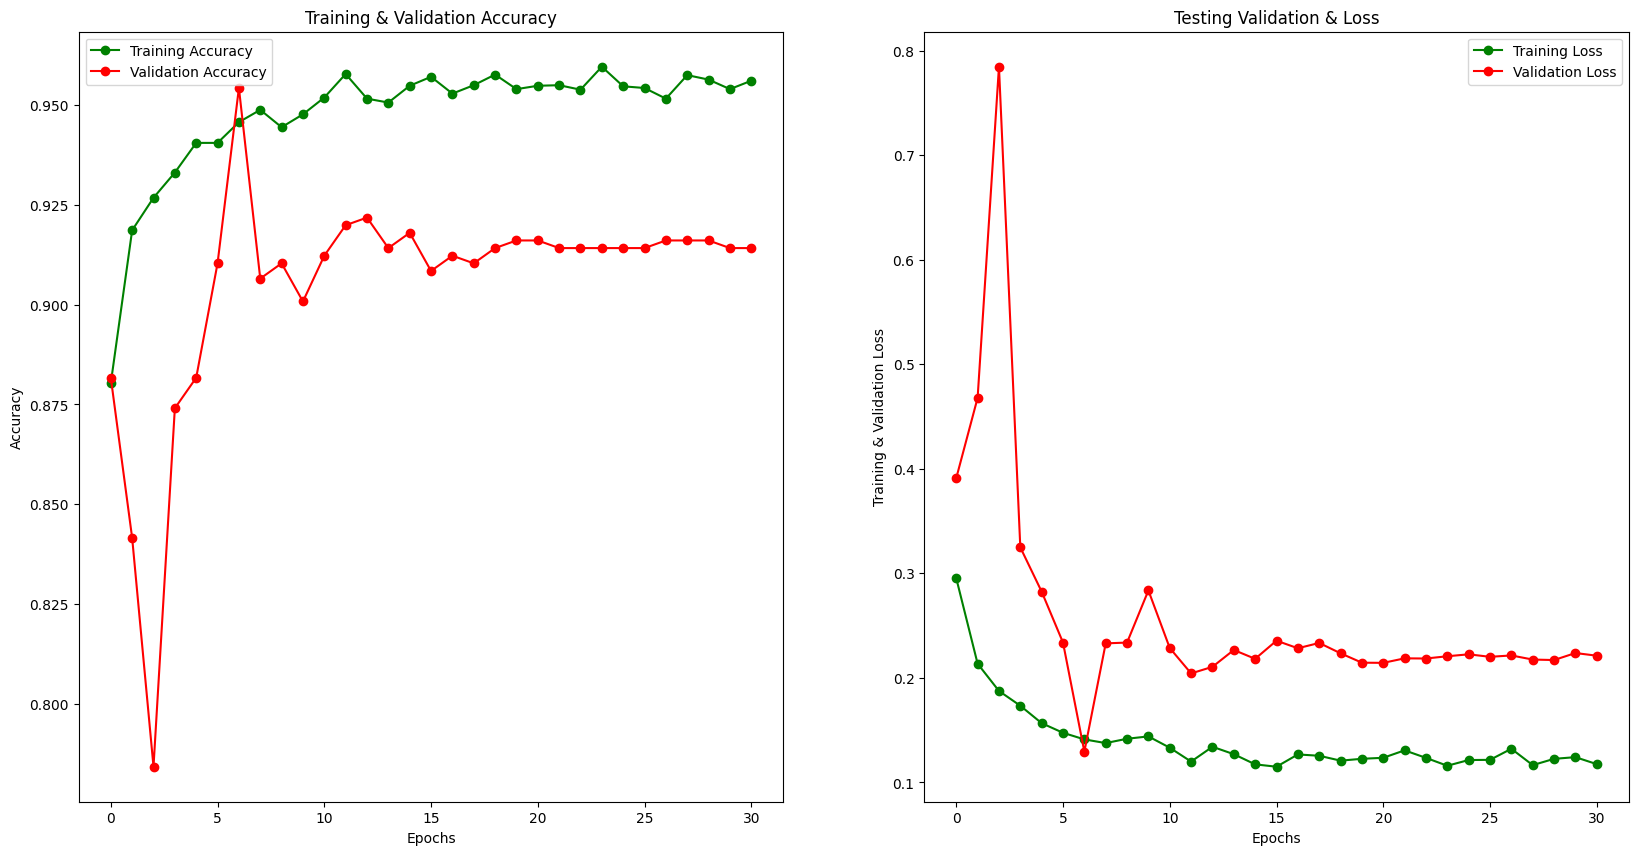

In [16]:
def plot_history(history, size = (20,10), epochs = 30):
    epochs = [i for i in range(epochs)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['categorical_accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Testing Validation & Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

plot_history(history, size=(20,10), epochs = 31)

In [27]:
model = keras.models.load_model("./efficient_net2/best_model_epoch_07.h5")

In [28]:
predictions_A = model.predict(X_test_A)
predictions_B = model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

14/14 [==============================] - 6s 416ms/step
Test Set A
                     precision    recall  f1-score   support

   Normal (Class 0)       0.95      0.90      0.93        70
Pneumonia (Class 1)       0.94      0.97      0.96       117

           accuracy                           0.95       187
          macro avg       0.95      0.94      0.94       187
       weighted avg       0.95      0.95      0.95       187


Test Set B
                     precision    recall  f1-score   support

   Normal (Class 0)       0.94      0.85      0.89       164
Pneumonia (Class 1)       0.92      0.97      0.94       273

           accuracy                           0.92       437
          macro avg       0.93      0.91      0.92       437
       weighted avg       0.93      0.92      0.92       437

Test Set A
[[ 63   7]
 [  3 114]]

Test Set B
[[140  24]
 [  9 264]]


In [29]:
best_model = keras.callbacks.ModelCheckpoint(filepath='./finetuned_efficient_net2/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"finetuned_efficient_net2/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [30]:
# Unfreeze the base model
model.trainable = True

In [31]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-5),  # Low learning rate
    loss = "categorical_crossentropy",
    metrics = ['accuracy'],
)

In [33]:
history = model.fit(datagen.flow(X_train_oversample,y_train_oversample, batch_size = 32), batch_size = 32, epochs = 11 , validation_data = (X_val, y_val) ,callbacks = [best_model,epoch_saver],)

Epoch 1/11
223/223 [==============================] - 522s 2s/step - loss: 0.1215 - accuracy: 0.9567 - val_loss: 0.0905 - val_accuracy: 0.9637
Epoch 2/11
223/223 [==============================] - 492s 2s/step - loss: 0.1190 - accuracy: 0.9599 - val_loss: 0.0778 - val_accuracy: 0.9733
Epoch 3/11
223/223 [==============================] - 488s 2s/step - loss: 0.1047 - accuracy: 0.9627 - val_loss: 0.0725 - val_accuracy: 0.9733
Epoch 4/11
223/223 [==============================] - 488s 2s/step - loss: 0.1096 - accuracy: 0.9617 - val_loss: 0.0716 - val_accuracy: 0.9733
Epoch 5/11
223/223 [==============================] - 519s 2s/step - loss: 0.1029 - accuracy: 0.9643 - val_loss: 0.0685 - val_accuracy: 0.9752
Epoch 6/11
223/223 [==============================] - 561s 3s/step - loss: 0.0921 - accuracy: 0.9664 - val_loss: 0.0667 - val_accuracy: 0.9714
Epoch 7/11
223/223 [==============================] - 543s 2s/step - loss: 0.0945 - accuracy: 0.9668 - val_loss: 0.0637 - val_accuracy: 0.9790

In [37]:
model = keras.models.load_model("./finetuned_efficient_net2/best_model_epoch_10.h5")

predictions_A = model.predict(X_test_A)
predictions_B = model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

14/14 [==============================] - 6s 449ms/step
Test Set A
                     precision    recall  f1-score   support

   Normal (Class 0)       1.00      0.86      0.92        70
Pneumonia (Class 1)       0.92      1.00      0.96       117

           accuracy                           0.95       187
          macro avg       0.96      0.93      0.94       187
       weighted avg       0.95      0.95      0.95       187


Test Set B
                     precision    recall  f1-score   support

   Normal (Class 0)       0.99      0.82      0.90       164
Pneumonia (Class 1)       0.90      1.00      0.95       273

           accuracy                           0.93       437
          macro avg       0.95      0.91      0.92       437
       weighted avg       0.94      0.93      0.93       437

Test Set A
[[ 60  10]
 [  0 117]]

Test Set B
[[135  29]
 [  1 272]]


In [8]:
model = keras.models.load_model("./efficient_net2/model_epoch_30.h5")

In [9]:
best_model = keras.callbacks.ModelCheckpoint(filepath='./finetuned_efficient_net3/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"finetuned_efficient_net3/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [10]:
# Unfreeze the base model
model.trainable = True

In [11]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-5),  # Low learning rate
    loss = "categorical_crossentropy",
    metrics = ['accuracy'],
)

In [16]:
history = model.fit(datagen.flow(X_train_oversample,y_train_oversample, batch_size = 32), batch_size = 32, epochs = 16 , validation_data = (X_val, y_val) ,callbacks = [best_model,epoch_saver],)

Epoch 1/16
223/223 [==============================] - ETA: 0s - loss: 0.4247 - accuracy: 0.8719

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


223/223 [==============================] - 602s 3s/step - loss: 0.4247 - accuracy: 0.8719 - val_loss: 0.4774 - val_accuracy: 0.8397
Epoch 2/16
223/223 [==============================] - 502s 2s/step - loss: 0.2129 - accuracy: 0.9239 - val_loss: 0.2286 - val_accuracy: 0.9179
Epoch 3/16
223/223 [==============================] - 591s 3s/step - loss: 0.1884 - accuracy: 0.9336 - val_loss: 0.1853 - val_accuracy: 0.9313
Epoch 4/16
223/223 [==============================] - 581s 3s/step - loss: 0.1712 - accuracy: 0.9362 - val_loss: 0.1569 - val_accuracy: 0.9427
Epoch 5/16
223/223 [==============================] - 573s 3s/step - loss: 0.1465 - accuracy: 0.9465 - val_loss: 0.1269 - val_accuracy: 0.9504
Epoch 6/16
223/223 [==============================] - 532s 2s/step - loss: 0.1290 - accuracy: 0.9532 - val_loss: 0.1152 - val_accuracy: 0.9618
Epoch 7/16
223/223 [==============================] - 548s 2s/step - loss: 0.1305 - accuracy: 0.9533 - val_loss: 0.0957 - val_accuracy: 0.9637
Epoch 8/16

In [18]:
model = keras.models.load_model("./finetuned_efficient_net3/model_epoch_15.h5")


predictions_A = model.predict(X_test_A)
predictions_B = model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

14/14 [==============================] - 5s 374ms/step
Test Set A
                     precision    recall  f1-score   support

   Normal (Class 0)       1.00      0.86      0.92        70
Pneumonia (Class 1)       0.92      1.00      0.96       117

           accuracy                           0.95       187
          macro avg       0.96      0.93      0.94       187
       weighted avg       0.95      0.95      0.95       187


Test Set B
                     precision    recall  f1-score   support

   Normal (Class 0)       0.97      0.80      0.88       164
Pneumonia (Class 1)       0.89      0.99      0.94       273

           accuracy                           0.92       437
          macro avg       0.93      0.90      0.91       437
       weighted avg       0.92      0.92      0.92       437

Test Set A
[[ 60  10]
 [  0 117]]

Test Set B
[[132  32]
 [  4 269]]


In [21]:
best_model = keras.callbacks.ModelCheckpoint(filepath='./finetuned_efficient_net4/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"finetuned_efficient_net4/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-5),  # Low learning rate
    loss = "categorical_crossentropy",
    metrics = ['accuracy'],
)

# Unfreeze the base model
model.trainable = True

In [22]:
history = model.fit(datagen.flow(X_train_oversample,y_train_oversample, batch_size = 32), batch_size = 32, epochs = 16 , validation_data = (X_val, y_val) ,callbacks = [best_model,epoch_saver],)

Epoch 1/16
223/223 [==============================] - ETA: 0s - loss: 0.0732 - accuracy: 0.9759

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


223/223 [==============================] - 735s 3s/step - loss: 0.0732 - accuracy: 0.9759 - val_loss: 0.0579 - val_accuracy: 0.9828
Epoch 2/16
223/223 [==============================] - 586s 3s/step - loss: 0.0712 - accuracy: 0.9772 - val_loss: 0.0579 - val_accuracy: 0.9828
Epoch 3/16
223/223 [==============================] - 606s 3s/step - loss: 0.0700 - accuracy: 0.9767 - val_loss: 0.0555 - val_accuracy: 0.9847
Epoch 4/16
223/223 [==============================] - 513s 2s/step - loss: 0.0690 - accuracy: 0.9755 - val_loss: 0.0564 - val_accuracy: 0.9828
Epoch 5/16
223/223 [==============================] - 2437s 11s/step - loss: 0.0630 - accuracy: 0.9804 - val_loss: 0.0618 - val_accuracy: 0.9752
Epoch 6/16
223/223 [==============================] - 490s 2s/step - loss: 0.0618 - accuracy: 0.9791 - val_loss: 0.0526 - val_accuracy: 0.9866
Epoch 7/16
223/223 [==============================] - 592s 3s/step - loss: 0.0587 - accuracy: 0.9804 - val_loss: 0.0521 - val_accuracy: 0.9847
Epoch 8/

In [53]:
model = keras.models.load_model("./finetuned_efficient_net4/best_model_epoch_07.h5")


predictions_A = model.predict(X_test_A)
predictions_B = model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

14/14 [==============================] - 8s 537ms/step
Test Set A
                     precision    recall  f1-score   support

   Normal (Class 0)       1.00      0.80      0.89        70
Pneumonia (Class 1)       0.89      1.00      0.94       117

           accuracy                           0.93       187
          macro avg       0.95      0.90      0.92       187
       weighted avg       0.93      0.93      0.92       187


Test Set B
                     precision    recall  f1-score   support

   Normal (Class 0)       0.99      0.80      0.89       164
Pneumonia (Class 1)       0.89      0.99      0.94       273

           accuracy                           0.92       437
          macro avg       0.94      0.90      0.91       437
       weighted avg       0.93      0.92      0.92       437

Test Set A
[[ 56  14]
 [  0 117]]

Test Set B
[[132  32]
 [  2 271]]


In [54]:
predictions_A_01 = [0 if a[0] > 0.01 else 1 for a in predictions_A]
predictions_B_01 = [0 if a[0] > 0.01 else 1 for a in predictions_B]

print("Test Set A")
print(classification_report(argmax_array(y_test_A), predictions_A_01, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),predictions_B_01, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), predictions_A_01))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), predictions_B_01))


Test Set A
                     precision    recall  f1-score   support

   Normal (Class 0)       0.89      0.97      0.93        70
Pneumonia (Class 1)       0.98      0.93      0.96       117

           accuracy                           0.95       187
          macro avg       0.94      0.95      0.94       187
       weighted avg       0.95      0.95      0.95       187


Test Set B
                     precision    recall  f1-score   support

   Normal (Class 0)       0.91      0.95      0.93       164
Pneumonia (Class 1)       0.97      0.95      0.96       273

           accuracy                           0.95       437
          macro avg       0.94      0.95      0.94       437
       weighted avg       0.95      0.95      0.95       437

Test Set A
[[ 68   2]
 [  8 109]]

Test Set B
[[156   8]
 [ 15 258]]
